In [56]:
# !conda install -c conda-forge librosa

# !conda install tqdm

In [67]:
import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import hyperparams
reload(hyperparams)
params = hyperparams.Hyperparams
import datasets
reload(datasets)
import dcttsModel
# from dcttsModel import C,Cs,Css,D,HC,TextEnc,AudioEnc,AudioDec,Text2Mel,SSRN
reload(dcttsModel)
import utils
# from utils import loadChkpt,saveChkpt
reload(utils)

<module 'utils' from '/home/aduriseti/tts/ettts/utils.py'>

In [68]:
# textEnc = dcttsModel.TextEnc(d=d,e=e,c2i=c2i)
# audioEnc = AudioEnc(d=d,F=F)
# audioDec = AudioDec(d=params.d,F=params.F).to(dev)

ssrn = dcttsModel.SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
text2Mel = dcttsModel.Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

# print tunable hyperparams
print('HYPERPARAMS',utils.paramDict)
[sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,ssrn)]


HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': False, 'norm': 1, 'lr': 0.001, 'chunk': 1}


[23970160, 24991247]

In [69]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

In [70]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A):
        _,N,T = A.shape
        W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*params.g**2)) 
                        for t in range(1,T+1)] 
                       for n in range(1,N+1)])
        W = W.to(dev)
        return ((1-W)*A).mean()

L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def MelFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [71]:
import datasets
from importlib import reload
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)

text2Mel = dcttsModel.Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                          lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 0
if load:
    startEpoch,lossHist,bestLoss = utils.loadChkpt(text2Mel,text2MelOpt,'text2Mel',dev)
else:
    # COLD START - RESET text2Mel
    print('COLD START')
    print('HYPERPARAMS',utils.paramDict)
    text2Mel = dcttsModel.Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)
    text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                      lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

COLD START
HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': False, 'norm': 1, 'lr': 0.001, 'chunk': 1}


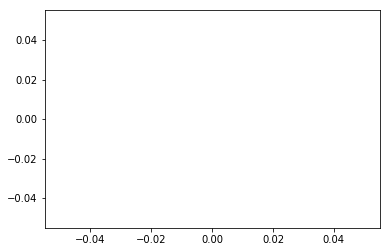

In [72]:
plt.plot(lossHist)

EPOCH 0



epoch 0 total 0.9620675781769539 mel 0.7959132194519043 att 0.0008725656080059707
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 1, LOSS 0.9620675781769539, BEST LOSS 0.9620675781769539 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


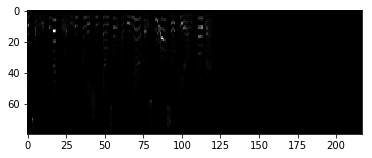

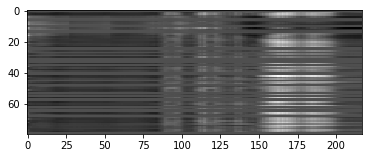

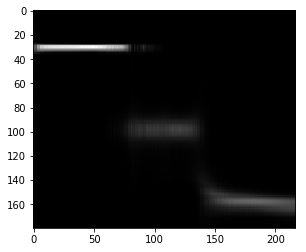

EPOCH 1



epoch 1 total 0.5897243689690064 mel 0.520797610282898 att 0.002681613201275468
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 2, LOSS 0.5897243689690064, BEST LOSS 0.5897243689690064 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


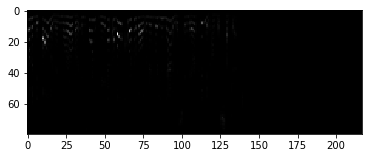

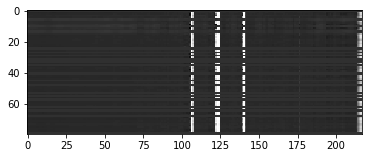

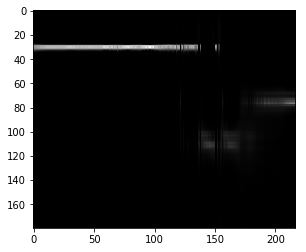

EPOCH 2



epoch 2 total 0.3456434310372196 mel 0.34853482246398926 att 0.0012141966726630926
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 3, LOSS 0.3456434310372196, BEST LOSS 0.3456434310372196 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


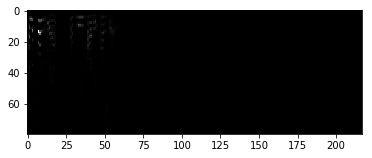

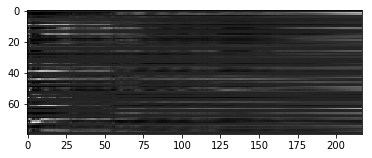

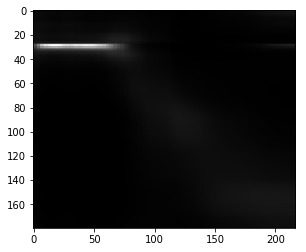

EPOCH 3



epoch 3 total 0.20089458734241883 mel 0.16230326890945435 att 0.0015278500504791737
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 4, LOSS 0.20089458734241883, BEST LOSS 0.20089458734241883 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


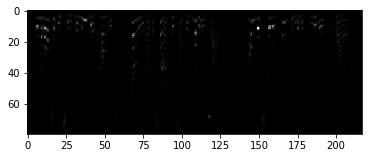


epoch 4 total 0.11755199293369678 mel 0.12765657901763916 att 0.0007042594952508807
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 5, LOSS 0.11755199293369678, BEST LOSS 0.11755199293369678 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


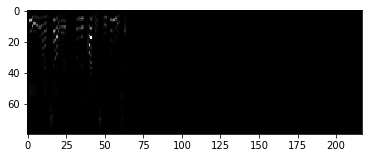

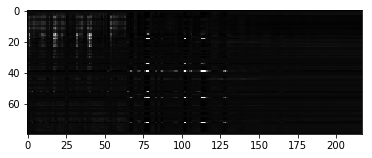

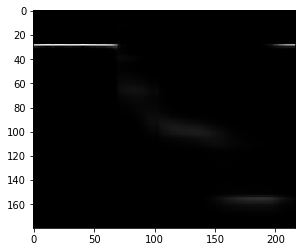

EPOCH 5



epoch 5 total 0.07457271251104661 mel 0.05307542532682419 att 0.0009125621290877461
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 6, LOSS 0.07457271251104661, BEST LOSS 0.07457271251104661 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


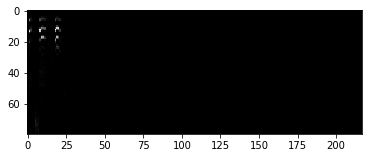

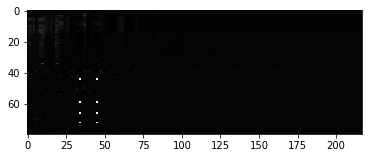

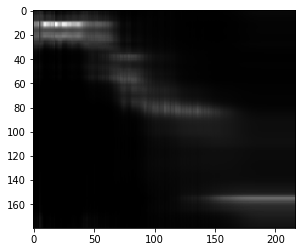

EPOCH 6



epoch 6 total 0.05218227735317465 mel 0.04896049201488495 att 0.0005008334410376847
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 7, LOSS 0.05218227735317465, BEST LOSS 0.05218227735317465 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


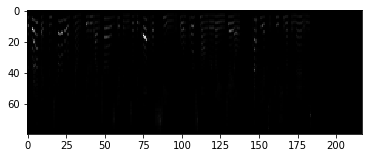

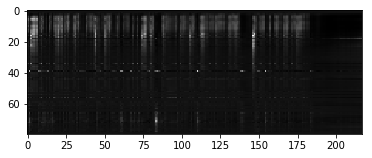

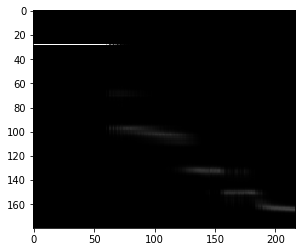

EPOCH 7



epoch 7 total 0.04197798046325125 mel 0.027787696570158005 att 0.0007012648275122046
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 8, LOSS 0.04197798046325125, BEST LOSS 0.04197798046325125 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


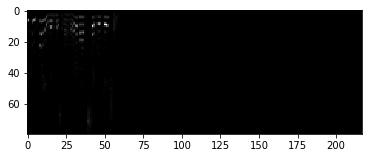

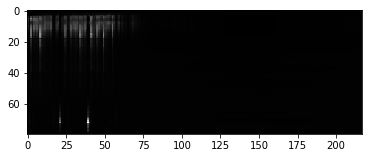

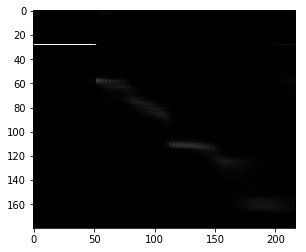

EPOCH 8



epoch 8 total 0.03741575375254919 mel 0.03341709077358246 att 0.0001831270637921989
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 9, LOSS 0.03741575375254919, BEST LOSS 0.03741575375254919 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


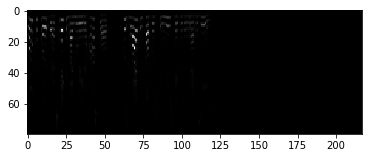

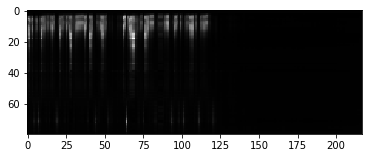

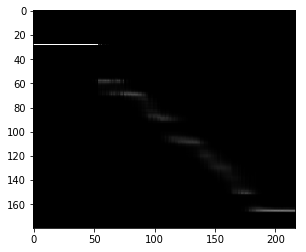

EPOCH 9



epoch 9 total 0.035349495578279246 mel 0.04468381777405739 att 0.0002651103714015335
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 10, LOSS 0.035349495578279246, BEST LOSS 0.035349495578279246 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


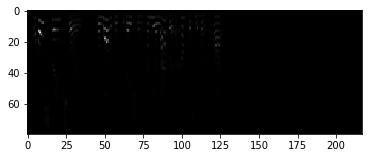

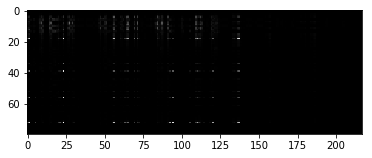

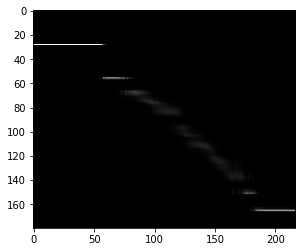

EPOCH 10



epoch 10 total 0.03404471715217206 mel 0.04158981144428253 att 0.00017762846255209297
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 11, LOSS 0.03404471715217206, BEST LOSS 0.03404471715217206 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelChkpt.pth.tar', './text2MelChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/text2MelBest.pth.tar', './text2MelBest.pth.tar']


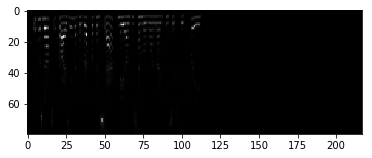

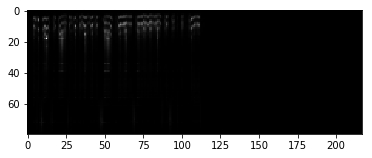

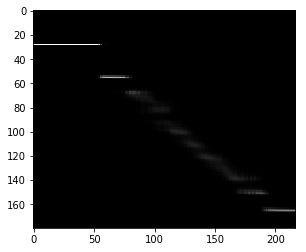

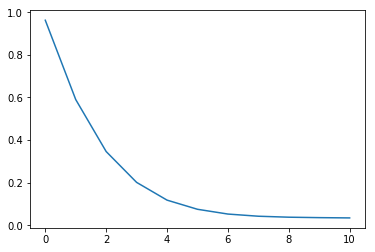

In [73]:
startEpoch = len(lossHist)
train = 1
for epoch in range(startEpoch,startEpoch+101*train):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(batchL,batchS,_) in tqdm.tqdm_notebook(enumerate(text2MelLoader)):
        batchL = batchL.to(dev)
        batchS = batchS.to(dev)
        bL = ch.autograd.Variable(batchL)
        bS = ch.autograd.Variable(batchS)
        Shat,A = text2Mel(bL,bS)
        melloss = MelFun(Shat[:,:,:-params.chunk],bS[:,:,params.chunk:])
        attloss = GAttFun(A)
        loss = melloss + attloss
        epochLoss.append(loss.data.item())
        text2MelOpt.zero_grad()
        loss.backward()
        text2MelOpt.step()
#         if step > 10: break
    lossHist.append(np.mean(epochLoss))
    print('epoch',epoch,'total',lossHist[-1],
      'mel',melloss.data.item(),'att',attloss.data.item())
    if epoch % 1 == 0:
        bestLoss = min(lossHist[-1],bestLoss)
        state = {
            'epoch': epoch + 1,
            'archparams': {'sep': params.sep, 'alpha': params.alpha},
            'modelState': text2Mel.state_dict(),
            'lossHist': lossHist,
            'bestLoss': bestLoss,
            'optimizerState': text2MelOpt.state_dict() 
        }
        utils.saveChkpt(state,model='text2Mel')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)

In [77]:
import datasets
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=nWorkers)

ssrn = dcttsModel.SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)

ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 0
if load:
    startEpoch,lossHist,bestLoss = utils.loadChkpt(ssrn,ssrnOpt,'ssrn',dev)
else:
    # COLD START - RESET SSRN
    ssrn = dcttsModel.SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
    ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

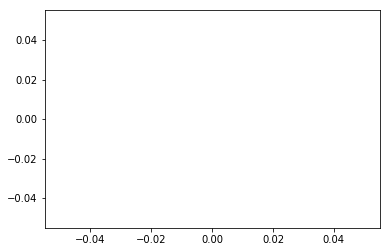

In [78]:
plt.plot(lossHist)

EPOCH 0



epoch 0 total 0.9474542155194638
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 0, LOSS 0.9474542155194638, BEST LOSS 0.9474542155194638 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


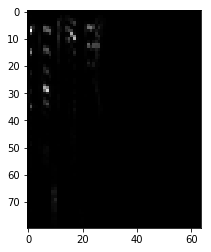

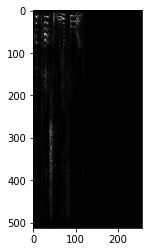

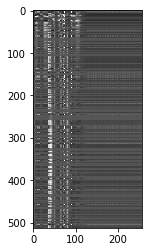

EPOCH 1



epoch 1 total 0.5860685908527516
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 1, LOSS 0.5860685908527516, BEST LOSS 0.5860685908527516 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


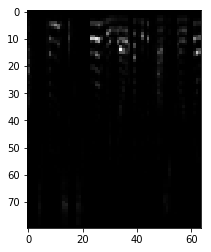

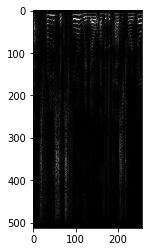

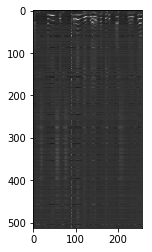

EPOCH 2



epoch 2 total 0.3531928749226812
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 2, LOSS 0.3531928749226812, BEST LOSS 0.3531928749226812 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


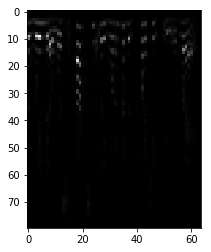

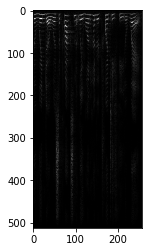

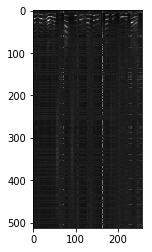

EPOCH 3



epoch 3 total 0.22089818913989992
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 3, LOSS 0.22089818913989992, BEST LOSS 0.22089818913989992 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


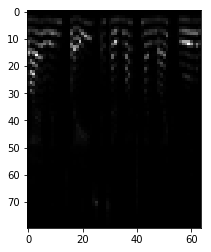

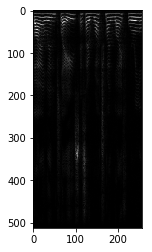

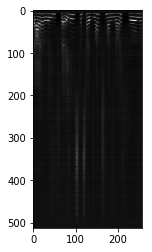

EPOCH 4



epoch 4 total 0.15269705713240067
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 4, LOSS 0.15269705713240067, BEST LOSS 0.15269705713240067 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


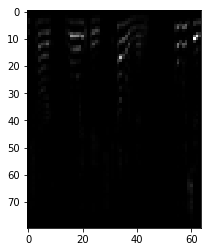

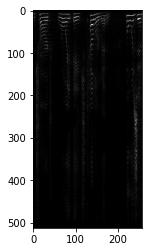

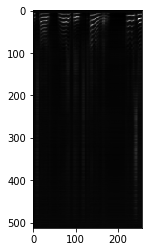

EPOCH 5



epoch 5 total 0.1230435558997873
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 5, LOSS 0.1230435558997873, BEST LOSS 0.1230435558997873 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


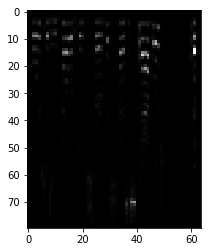

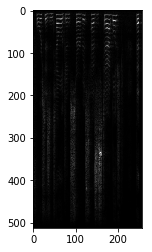

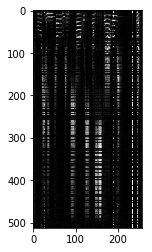

EPOCH 6



epoch 6 total 0.11512384990702815
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 6, LOSS 0.11512384990702815, BEST LOSS 0.11512384990702815 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


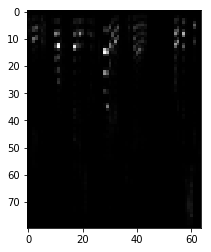

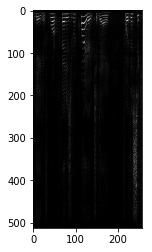

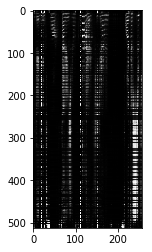

EPOCH 7



epoch 7 total 0.11011668905170996
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 7, LOSS 0.11011668905170996, BEST LOSS 0.11011668905170996 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


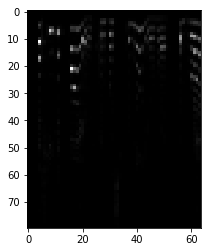

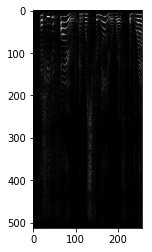

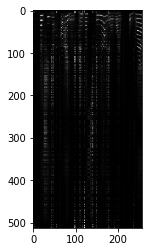

EPOCH 8



epoch 8 total 0.10434518675528355
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 8, LOSS 0.10434518675528355, BEST LOSS 0.10434518675528355 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


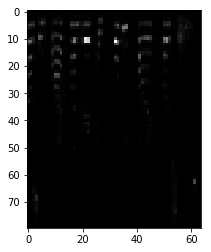

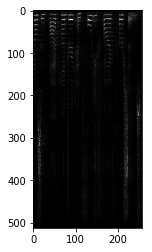

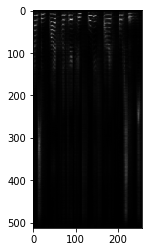

EPOCH 9



epoch 9 total 0.1037245900217277
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 9, LOSS 0.1037245900217277, BEST LOSS 0.1037245900217277 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


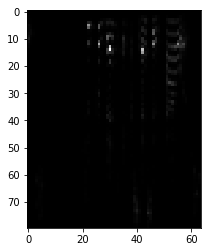

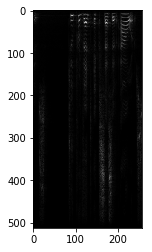

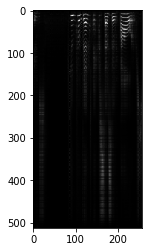

EPOCH 10



epoch 10 total 0.1031965022990063
HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
SAVED EPOCH 10, LOSS 0.1031965022990063, BEST LOSS 0.1031965022990063 TO ['./sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnChkpt.pth.tar', './ssrnChkpt.pth.tar', './sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1/ssrnBest.pth.tar', './ssrnBest.pth.tar']


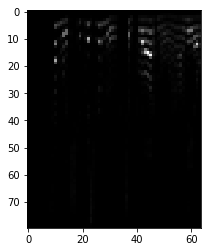

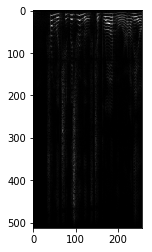

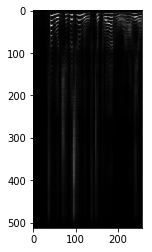

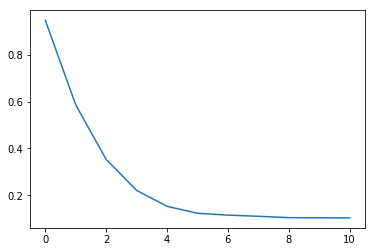

In [79]:
startEpoch = len(lossHist)
train = 1
for epoch in range(startEpoch,startEpoch+21*train):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(_,batchS,batchY) in tqdm.tqdm_notebook(enumerate(ssrnLoader)):
        batchS = batchS.to(dev)
        batchY = batchY.to(dev)
        bS = ch.autograd.Variable(batchS)
        bY = ch.autograd.Variable(batchY)
        Yhat = ssrn(bS)
        loss = MelFun(Yhat,bY)
        epochLoss.append(loss.data.item())
        ssrnOpt.zero_grad()
        loss.backward()
        ssrnOpt.step()
#         if step > 1: break
    lossHist.append(np.mean(epochLoss))
    bestLoss = min(bestLoss,lossHist[-1])
    print('epoch',epoch,'total',lossHist[-1])
    if epoch % 1 == 0:
        state = {
            'epoch': epoch,
            'modelState': ssrn.state_dict(),
            'lossHist': lossHist,
            'bestLoss': bestLoss,
            'optimizerState': ssrnOpt.state_dict() 
        }
        utils.saveChkpt(state,model='ssrn')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(bY[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)